# Final project - Jedha - Data Essentials
## Energy consumption - classification and prediction
##### Authors: Daniel Gil, Sarah Sahli
##### Date: 04/08/2023

## Data importation and preprocessing

In [744]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import pytz
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# Uncomment line below to install prophet package if not already installed
# pip install prophet
from prophet import Prophet
import logging
# Set the logging level to WARNING (or ERROR) to silence INFO messages
logging.getLogger("prophet").setLevel(logging.WARNING)

In [745]:
# Get current directory for dataset import
import os
current_directory = os.getcwd()

In [746]:
# Import dataset
hourly_conso = pd.read_csv(current_directory + '/out.csv')
hourly_conso.head()

,Unnamed: 0,meter_serial,start,end,active_energy_imported,active_energy_exported,reactive_energy_imported,reactive_energy_exported,perfil,conjunto
0,12789,2221437470,2022-12-31T20:00:00.000Z,2022-12-31T21:00:00.000Z,1027.698000,0.0,212.22858,21.400000,0,Portelo
1,12790,2221437470,2022-12-31T21:00:00.000Z,2022-12-31T22:00:00.000Z,82.229460,0.0,0.00000,40.858930,0,Portelo
2,12791,2221437470,2022-12-31T22:00:00.000Z,2022-12-31T23:00:00.000Z,74.004684,0.0,0.00000,41.163837,0,Portelo
3,12792,2221437470,2022-12-31T23:00:00.000Z,2023-01-01T00:00:00.000Z,45.490852,0.0,0.00000,37.170986,0,Portelo
4,12793,2221437470,2023-01-01T00:00:00.000Z,2023-01-01T01:00:00.000Z,68.890940,0.0,0.00000,38.438120,0,Portelo


In [747]:
# Select only relevant columns
columns_to_drop = ['Unnamed: 0', 'end', 'active_energy_exported', 'reactive_energy_imported', 'reactive_energy_exported', 'perfil', 'conjunto']
hourly_conso.drop(columns_to_drop, axis=1, inplace=True)

# Change the data types of columns
hourly_conso['meter_serial'] = hourly_conso['meter_serial'].astype(str)
hourly_conso['start'] = pd.to_datetime(hourly_conso['start'])

# Rename columns to have meaningful names
hourly_conso.rename(columns={'start' : 'measurement_start', 'active_energy_imported' : 'energy_consumed (Wh)'}, inplace=True)

# Display info on updated dataframe
print(hourly_conso.head())
print()
print(hourly_conso.info())


  meter_serial         measurement_start  energy_consumed (Wh)
0   2221437470 2022-12-31 20:00:00+00:00           1027.698000
1   2221437470 2022-12-31 21:00:00+00:00             82.229460
2   2221437470 2022-12-31 22:00:00+00:00             74.004684
3   2221437470 2022-12-31 23:00:00+00:00             45.490852
4   2221437470 2023-01-01 00:00:00+00:00             68.890940

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016943 entries, 0 to 1016942
Data columns (total 3 columns):
 #   Column                Non-Null Count    Dtype              
---  ------                --------------    -----              
 0   meter_serial          1016943 non-null  object             
 1   measurement_start     1016943 non-null  datetime64[ns, UTC]
 2   energy_consumed (Wh)  1016710 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 23.3+ MB
None


In [748]:
# Convert datetime with UTC timezone to Colombian time
colombia_tz = pytz.timezone('America/Bogota')
hourly_conso['measurement_start'] = hourly_conso['measurement_start'].dt.tz_convert(colombia_tz)

# Remove timezone info after converting to local time
hourly_conso['measurement_start'] = hourly_conso['measurement_start'].dt.tz_localize(None)

# Select days when data is complete for all meters
period_start_str = '2023-01-01T00:00:00'
period_start = datetime.fromisoformat(period_start_str)
period_end_str = '2023-06-26T23:00:00'
period_end = datetime.fromisoformat(period_end_str)

# Filter out dates outside above-mentionned period
hourly_conso = hourly_conso[(hourly_conso['measurement_start'] >= period_start) & (hourly_conso['measurement_start'] <= period_end)]

# Display updated dataframe
print(hourly_conso)

        meter_serial   measurement_start  energy_consumed (Wh)
9         2221437470 2023-01-01 00:00:00             474.38242
10        2221437470 2023-01-01 01:00:00             130.56113
11        2221437470 2023-01-01 02:00:00             127.72523
12        2221437470 2023-01-01 03:00:00             151.88055
13        2221437470 2023-01-01 04:00:00             155.63144
...              ...                 ...                   ...
1016932   2221459840 2023-06-26 19:00:00            1892.79580
1016933   2221459840 2023-06-26 20:00:00            1821.19810
1016934   2221459840 2023-06-26 21:00:00            1776.69920
1016935   2221459840 2023-06-26 22:00:00            1751.02750
1016936   2221459840 2023-06-26 23:00:00            1711.79520

[989784 rows x 3 columns]


In [749]:
# Check if there are missing values
hourly_conso.isnull().any()

meter_serial            False
measurement_start       False
energy_consumed (Wh)    False
dtype: bool

In [750]:
# Dataset's statistics
hourly_conso.describe()

,energy_consumed (Wh)
count,989784.000000
mean,440.888691
std,556.886831
min,0.000000
25%,80.142498
50%,197.249915
75%,605.709660
max,6050.623000


In [751]:
# Extract updated dataframe to csv file
# hourly_conso.to_csv('hourly_conso.csv', index=False)

In [752]:
# Create dataframe with daily consumption per meter
daily_conso = hourly_conso
daily_conso['day'] = daily_conso['measurement_start'].dt.date
daily_conso = daily_conso.groupby(by=['meter_serial', 'day'])['energy_consumed (Wh)'].sum().reset_index()

# Add a column to determine if daily consumption is below a specific threshold
# This threshold will be used to determine whether property seems occupied or empty (standy power consumption)
threshold = 4000 # corresponds to average daily consumption per person in Colombia. 
daily_conso['very_low'] = (daily_conso['energy_consumed (Wh)'] < threshold)

# Dataset's statistics
daily_conso.describe()

,energy_consumed (Wh)
count,41241.000000
mean,10581.328577
std,8959.281991
min,0.000000
25%,3259.020193
50%,8696.364709
75%,15589.464320
max,78279.574700


In [753]:
# Extract df_days dataframe to csv file
# daily_conso.to_csv('daily_conso.csv', index=False)

## Classification

Methodology:
- Classify meters according to their mean energy consumption across studied period, excluding days when consumption is below 4kWh (assumed to be days when property is vacant)
- We exclude days when property seems vacant in order to classify meters according to their "typical" consumption
- We use KMeans algorithm for classification based on mean energy consumption

In [754]:
# Create dataframe which filters out days when consumption is very_low
daily_conso_abv_threshold = daily_conso[daily_conso['very_low'] == False]
daily_conso_abv_threshold

,meter_serial,day,energy_consumed (Wh),very_low
177,2221437357,2023-01-01,29140.565690,False
178,2221437357,2023-01-02,30997.418260,False
179,2221437357,2023-01-03,25856.733320,False
180,2221437357,2023-01-04,31781.872610,False
181,2221437357,2023-01-05,28022.073950,False
...,...,...,...,...
41236,2222007080,2023-06-22,6316.502890,False
41237,2222007080,2023-06-23,7248.853330,False
41238,2222007080,2023-06-24,6337.635470,False
41239,2222007080,2023-06-25,9065.416731,False


In [755]:
# Create dataframe with mean energy consumption, excluding days when consumption is below threshold
mean_conso_abv_threshold = daily_conso_abv_threshold.groupby(by='meter_serial')['energy_consumed (Wh)'].mean().reset_index()
mean_conso_abv_threshold['energy_consumed (Wh)'] = mean_conso_abv_threshold['energy_consumed (Wh)']/1000 #convert Wh to KWh
mean_conso_abv_threshold.rename(columns={'energy_consumed (Wh)' : 'mean_energy (KWh)'}, inplace=True)
mean_conso_abv_threshold

,meter_serial,mean_energy (KWh)
0,2221437357,26.471360
1,2221437360,29.368035
2,2221437361,12.778893
3,2221437362,7.438247
4,2221437363,15.802416
...,...,...
221,2222007076,11.072107
222,2222007077,9.339464
223,2222007078,21.785810
224,2222007079,15.360481


In [756]:
# Apply K-Means algorithm to do classification

kmeans = KMeans(n_clusters=3, random_state=5) # adding random_state to get same cluster labels order everytime program is run
mean_conso_abv_threshold["Cluster"] = kmeans.fit_predict(mean_conso_abv_threshold[['mean_energy (KWh)']])
mean_conso_abv_threshold["Cluster"] = mean_conso_abv_threshold["Cluster"].astype(str)

mean_conso_abv_threshold.head(10)

/Users/sarahsahli/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,meter_serial,mean_energy (KWh),Cluster
0,2221437357,26.471360,2
1,2221437360,29.368035,2
2,2221437361,12.778893,1
3,2221437362,7.438247,0
4,2221437363,15.802416,1
5,2221437365,18.218046,1
6,2221437366,11.814054,0
7,2221437367,14.940520,1
8,2221437368,12.762421,1
9,2221437369,30.868491,2


In [757]:
# Change cluster labels
label_mapping = {'0': 'Low', '1': 'Medium', '2': 'High'}
mean_conso_abv_threshold['Cluster'] = mean_conso_abv_threshold['Cluster'].replace(label_mapping)

In [758]:
# Find the range of mean energy consumption for each cluster, and number of meters per cluster
clusters = mean_conso_abv_threshold.groupby('Cluster')['mean_energy (KWh)'].agg(['min', 'max', 'count'])
clusters = clusters.sort_values(by='min')
clusters

,min,max,count
Cluster,,,
Low,4.232064,12.296670,104
Medium,12.624421,20.923492,94
High,21.573365,32.825399,28


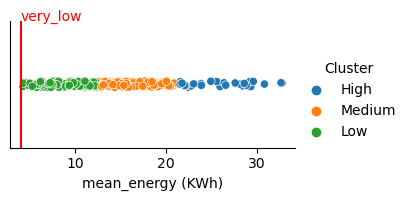

In [759]:
# Display K-means results on a graph with small dispersion along y-axis for better visibility

# Create a new DataFrame to store the modified data with added noise
df_graph = mean_conso_abv_threshold.copy()

# Define the amount of noise to be added to the y-coordinate of each data point
noise_scale = 0.1  # Adjust this value as needed to control the dispersion

# Loop through each unique cluster and add noise to the y-coordinates
for cluster in df_graph['Cluster'].unique():
    # Get the indices of the data points belonging to the current cluster
    cluster_indices = df_graph['Cluster'] == cluster
    
    # Calculate the number of data points in the current cluster
    num_points = np.sum(cluster_indices)
    
    # Generate random noise for the y-coordinates of the current cluster
    noise = np.random.uniform(-noise_scale, noise_scale, num_points)    

    # Add the noise to the y-coordinates of the current cluster
    df_graph.loc[cluster_indices, 'y_coordinate'] = noise

# Now create the scatter plot with the modified data
sns.relplot(
    x="mean_energy (KWh)", y="y_coordinate", hue="Cluster", data=df_graph, aspect=2, height=2
)

plt.ylim(-2, 2)
plt.yticks([])
plt.ylabel("")
plt.axvline(x=4, color='red', linestyle='-', label='very_low')
plt.text(4, 2, 'very_low', color='red', fontsize=10)
plt.show()

Text(0.5, 1.0, 'Mean Daily Consumption per Cluster')

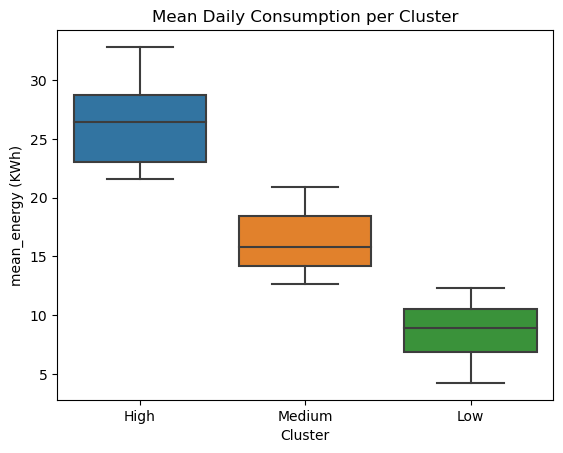

In [760]:
# Box plots of mean energy consumption for each cluster
sns.boxplot(x='Cluster', y='mean_energy (KWh)', data=mean_conso_abv_threshold)
plt.title('Mean Daily Consumption per Cluster')


## Prediction 

Methodology:
- We select only meters that belong to 'High' consumption cluster because they have greater impact on total load
- We also select only meters with daily consumption above 'very_low' consumption threshold during the whole period to have more accurate prediction
- We plan to predict energy consumption for last week of the studied period using historical data
- We use the prophet librabry for prediction

In [761]:
# Extract meters in Cluster "High" for which daily conso never goes below threshold 

# Extract meters in Cluster "High"
cluster_high = mean_conso_abv_threshold[mean_conso_abv_threshold['Cluster'] == 'High'].iloc[:, 0]
cluster_high

# Extract meters for which daily conso never goes below threshold
very_low = daily_conso.groupby(by='meter_serial')['very_low'].any()
meter_selection = very_low[very_low == False].reset_index()['meter_serial']
meter_selection

# Find intersections of both 
intersection = set(cluster_high).intersection(set(meter_selection))
intersection = list(intersection)
intersection # it includes 7 meters, we will do the prediction on these ones


['2222006661',
 '2221437357',
 '2221437385',
 '2221437575',
 '2221437661',
 '2221437410',
 '2221437360']

In [762]:
# Function to calculate the score of the prediction model
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [763]:
# Create function that will print predicted vs real values, and return score of the model

# Prediction is for the last week of the dataset from Monday 19th 2023 to Sunday 25th June 2023

def predict_last_7_days(daily_conso, meter_serial):

    # Select daily consumption for specific meter
    X = daily_conso[daily_conso['meter_serial'] == meter_serial]

    # Extract train set
    X_train = X.iloc[:-8, 1:3]
    X_train.rename(columns = {'energy_consumed (Wh)':'y', 'day':'ds'}, inplace=True)

    # Extract test set
    X_test = X.iloc[-8:-1, 1:3] #last day of dataset is a Monday so we exclude this day and take the whole week before

    # Determine average weekly profile based on train set, to be compared with real values and predictions
    profile = X_train
    profile['dow'] = pd.to_datetime(X_train['ds']).dt.day_name()
    profile = profile.groupby('dow')['y'].mean()
    week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    profile.reindex(week_days)
    
    # Train the prophet algorithm on train set
    m = Prophet()
    m.fit(X_train)

    # Make a forecast for next 7 days
    future = m.make_future_dataframe(freq='D', periods=7)
    future_forecast = m.predict(future)

    # Extract real values and predicted ones
    real_values = X_test.iloc[:,1].values
    predicted_values = future_forecast['yhat'][-7:].values

    # # Extract day of week 
    # days = X_test['day']
    # days = pd.to_datetime(days)
    # days = days.dt.day_name()

    # Plot real values, predicted values, and average weekly profile
    plt.figure()
    plt.bar(week_days, real_values, width=0.3, align='center', label='Real Values', color='blue', alpha=0.7)
    plt.bar(week_days, predicted_values, width=0.3, align='edge', label='Predicted Values', color='red', alpha=0.7)
    plt.plot(week_days, profile, label='Weekly Profile', color='green')

    # Add labels and title to the plot
    plt.xlabel('Day of week')
    plt.ylabel('Daily consumption (Wh)')
    plt.title('Real Values vs. Predicted Values, and Weekly Profile for Meter: ' + meter_serial)
    plt.legend()

    # Return mean absolute percentage error for the model
    return round(mean_absolute_percentage_error(real_values, predicted_values), 2)

    

12:21:04 - cmdstanpy - INFO - Chain [1] start processing
12:21:04 - cmdstanpy - INFO - Chain [1] done processing


13.66

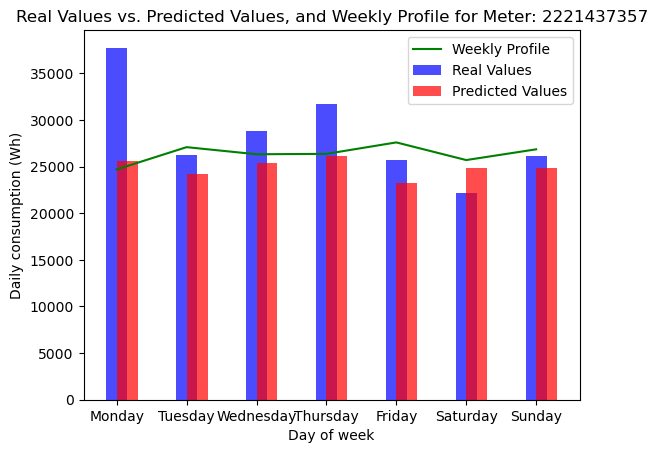

In [764]:
# Run the prediction function on a specific meter
meter_serial = '2221437357' # update serial meter for prediction
predict_last_7_days(daily_conso, meter_serial)

12:21:05 - cmdstanpy - INFO - Chain [1] start processing
12:21:05 - cmdstanpy - INFO - Chain [1] done processing


12:21:06 - cmdstanpy - INFO - Chain [1] start processing
12:21:06 - cmdstanpy - INFO - Chain [1] done processing
12:21:07 - cmdstanpy - INFO - Chain [1] start processing
12:21:07 - cmdstanpy - INFO - Chain [1] done processing
12:21:07 - cmdstanpy - INFO - Chain [1] start processing
12:21:07 - cmdstanpy - INFO - Chain [1] done processing
12:21:07 - cmdstanpy - INFO - Chain [1] start processing
12:21:07 - cmdstanpy - INFO - Chain [1] done processing
12:21:07 - cmdstanpy - INFO - Chain [1] start processing
12:21:07 - cmdstanpy - INFO - Chain [1] done processing
12:21:08 - cmdstanpy - INFO - Chain [1] start processing
12:21:08 - cmdstanpy - INFO - Chain [1] done processing


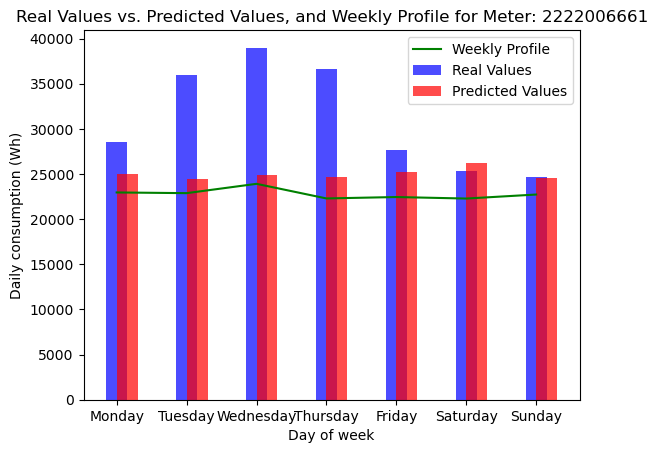

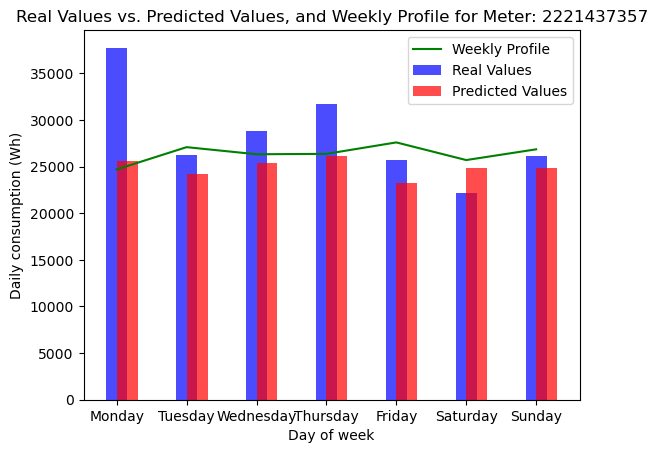

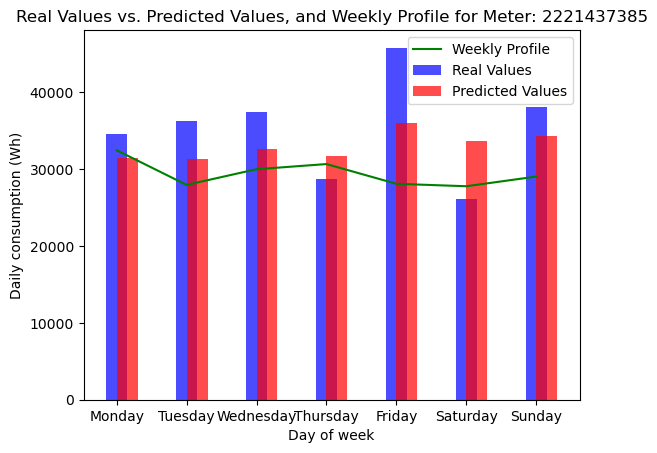

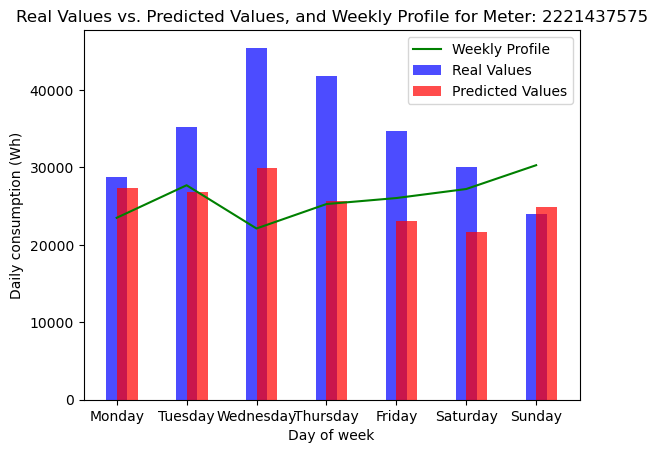

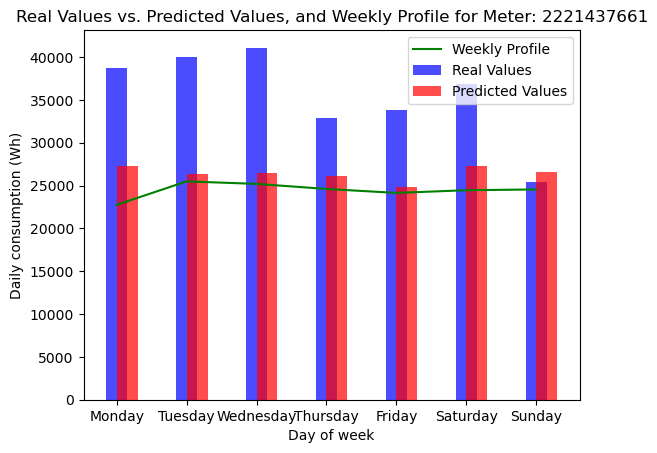

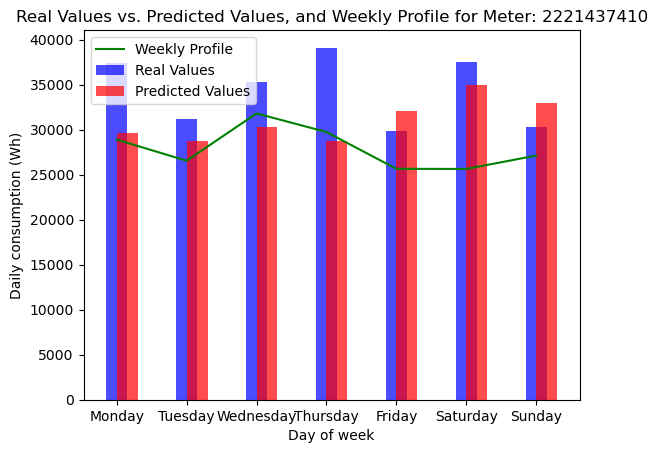

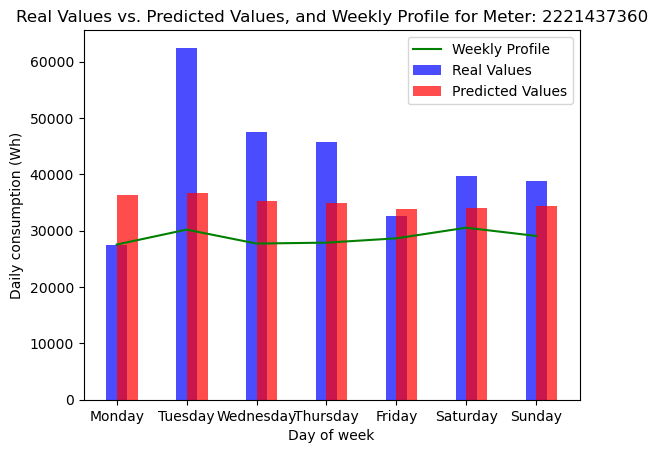

In [765]:
# Run the prediction on 7 meters
meters_scores = {}

for meter in intersection:
    meters_scores[meter] = round(predict_last_7_days(daily_conso, meter), 2)
    # print("Score for {} is: {}".format(meter, predict_last_7_days(daily_conso, meter)))

In [766]:
# Print results for the 7 meters
print("Score for each meter:", meters_scores)
print("Average score for the 7 meters:", round(np.mean(list(meters_scores.values())), 2))

Score for each meter: {'2222006661': 17.9, '2221437357': 13.66, '2221437385': 15.15, '2221437575': 23.73, '2221437661': 25.25, '2221437410': 13.21, '2221437360': 21.7}
Average score for the 7 meters: 18.66
